# G$^2$Pnet: The Grassmanian Gaussian Process Network
We check the implementation of G2PnetSolver (ver 6.) with conjugate gradient descent class in ../src/

Created by Tianpei Xie, 04/13/2016

Last Edit 04/14/2016

In [1]:
%reset
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.metrics.pairwise import rbf_kernel, pairwise_kernels
import GPy
import GPy.util as gutil

%matplotlib inline 
plt.close('all')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


/Applications/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
Ifsavefig =  True
Ifsavedata = False #True
trial = 9

In [3]:
G=nx.read_adjlist("../data/04_01_2016_experiment8.adjlist")

size = 40
color_map = {0:'r', 1:'c', 2:'y'}
#center = np.zeros(2)
#center[1] = 1
center = None

n = 40
m = 0
G0= nx.barbell_graph(n,m) 
#generate the bar-bell graph, which consists of two fully connected component and a path connecting them 

label0 = np.zeros([2*n,1])
label0[n:2*n] = np.ones([n,1])
#### labeling of the cluster
for node in G0.nodes():
    G0.node[node]['category'] = int(label0[node,0])

In [4]:
data_df = pd.read_csv("../data/04_01_2016_experiment8_X.csv", index_col = 'ID')
spectral_df = pd.read_csv("../data/04_01_2016_experiment8_U.csv", index_col ='ID')
U_init_pd = pd.read_csv("../data/04_01_16_8_U_init.csv", index_col = 0)

In [5]:
X = data_df.loc[:,['0_cos','1_cos']].values
U = spectral_df.loc[:,['PX','PY']].values
labels = data_df.loc[:,'LABEL'].values
U_init = U_init_pd.loc[:,['0','1']].values

In [6]:
nsample, ndim = X.shape
_ , ndim_latent = U.shape

In [7]:
import sys
import os
dirorg = os.path.dirname(os.getcwd())
sys.path.insert(0, dirorg+"/src/")

In [8]:
import G2PnetSolver_v6 #G2PnetSolver_v2
#from imp import reload
#reload(G2PnetSolver_v2)

In [9]:
from G2PnetSolver_v6 import  G2PnetSolver as Solver
from G2PnetSolver_v6 import  Grassmann_update, check_step

In [10]:
choice = "near"
IfGen = False

In [11]:
if IfGen:
    np.random.seed(seed=150)

    if choice == "random":
        print("Random Initialization")
        Temp = np.random.randn(nsample, nsample)
        Temp_sym = (Temp + Temp.T) / 2 
        _, U_temp = np.linalg.eig(Temp_sym)
        U_test = U_temp[:, np.arange(ndim_latent)]
        U0 = U_test
    elif choice == "near":
        print("Initialization in neigborhood.")
        U0 = U

    eta0 = 0.75
    np.random.seed(seed=160)
    G_temp = np.random.randn(nsample, ndim_latent) / (np.sqrt(nsample * ndim_latent))
    H_temp = -np.dot((np.eye(nsample) - gutil.linalg.tdot(U0)),G_temp)
    print(str(check_step(H_temp, eta0)))
    while not check_step(H_temp, eta0):
        np.random.seed(seed=160)
        G_temp = np.random.randn(nsample, ndim_latent) / np.sqrt(nsample * ndim_latent)
        H_temp = -np.dot((np.eye(nsample) - gutil.linalg.tdot(U0)),G_temp)
    U_init = Grassmann_update(U0, H_temp, eta=eta0)

In [12]:
if Ifsavedata:
    U_columns = [str(i) for i in np.arange(ndim_latent)]
    U_df = pd.DataFrame(data = U_init, columns=U_columns, dtype= float)
    if choice == "random":
        U_df['RANDOM'] = np.ones([nsample, 1])
    elif choice == "near":
        U_df['RANDOM'] = np.zeros([nsample, 1])
    
    U_df.to_csv("../data/04_14_16_" + str(trial)  + "_U_init.csv")

In [13]:
add_reg = True
max_iters = 600
eta_array = np.array([2e-3])
kern_array = [GPy.kern.RBF(2) + GPy.kern.White(2) for i in np.arange(len(eta_array))]
kern_grass_array = [GPy.kern.RBF(2)+ GPy.kern.White(2)  for i in np.arange(len(eta_array))]
kern_conjugate_grass_array = [GPy.kern.RBF(2)+ GPy.kern.White(2) for i in np.arange(len(eta_array))]
noise_interval = np.array([0.24,0.25])

In [14]:
solver_array = []
hist_nll_eu_array = []
hist_nll_grass_array = []
hist_nll_conjugate_grass_array = []
hist_Hsig_array = []
hist_Hsig_conjugate_array = []
hist_Gnorm_array = []
hist_Gnorm_conjugate_array = []
hist_gamma_array = []
hist_deltaG_array = []
hist_condK_array = []
hist_condK_grass_array = []
hist_condK_conjugate_array = []
hist_cond2K_array = []
hist_cond2K_grass_array = []
hist_cond2K_conjugate_array = []
hist_kern_eu_array = []
hist_kern_grass_array = []
hist_kern_grass2_array = []

kernel initialization ...
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s03  006   1.521277e+02   3.388662e+00 
    00s05  011   1.509680e+02   2.834833e-01 
    00s07  014   1.509608e+02   2.886642e-04 
    00s11  021   1.509592e+02   9.695912e-07 
    00s11  022   1.509592e+02   9.695912e-07 
Runtime:     00s11
Optimization status: Converged

negative log-likelihood compute
[step   0] neg-log-likelihood 70.149776 stepsize 0.0020
The gradient of L w.r.t. U not been computed. Just compute it anyway.
The gradient of L w.r.t K not been computed. Just compute it anyway.
The gradient of K w.r.t. U not been computed. Just compute it anyway
[step   1] neg-log-likelihood 66.801549 stepsize 0.0020
[step   2] neg-log-likelihood 66.234467 stepsize 0.0020
[step   3] neg-log-likelihood 65.306132 stepsize 0.0020
[step   4] neg-log-likelihood 64.115961 stepsize 0.0020
[step   5] neg-log-likelihood 63.061386 stepsize 0.0020
[step   6] neg-log-likelih

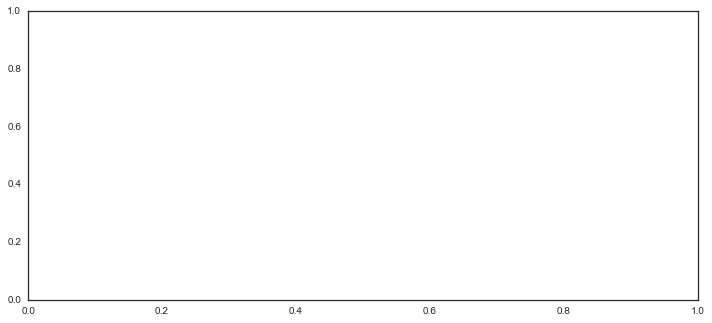

In [15]:
fig= plt.figure(1)
fig.set_size_inches(12.0, 30.0)
plt.style.use('seaborn-white')
lambda_var = 1


for i, eta in enumerate(eta_array): 
    ax = plt.subplot(5,1,i+1)
    solver = Solver(X=X, U=U_init, kernel=kern_array[i], U_ref= U, \
                    noise_interval = noise_interval, add_reg = add_reg, lambda_var = lambda_var, eta=eta)
    hist_nll_eu, hist_eta, hist_kern_eu, hist_Hsig_eu = solver.optimize(max_iters = max_iters, optimizor = "gd")
    solver_array.append(solver)
    hist_cond2K_array.append(solver.hist_cond_dK)
    hist_condK_array.append(solver.hist_cond_K)
    hist_nll_eu_array.append(hist_nll_eu)
    hist_kern_eu_array.append(hist_kern_eu)
    
    
    solver2 = Solver(X=X, U=U_init, kernel=kern_grass_array[i], U_ref = U, \
                     noise_interval = noise_interval, add_reg = add_reg, lambda_var = lambda_var, eta=eta)
    hist_nll_grass, hist_eta, hist_kern_grass, hist_Hsig_grass = \
                      solver2.optimize(max_iters = max_iters, optimizor = "gd_grass")
    hist_Hsig_array.append(hist_Hsig_grass)
    hist_Gnorm_array.append(solver2.hist_G_norm)
    hist_cond2K_grass_array.append(solver2.hist_cond_dK)
    hist_condK_grass_array.append(solver2.hist_cond_K)
    
    solver_array.append(solver2)
    hist_nll_grass_array.append(hist_nll_grass)
    hist_kern_grass_array.append(hist_kern_grass)
    
    solver3 = Solver(X=X, U=U_init, kernel=kern_conjugate_grass_array[i], U_ref = U, \
                     noise_interval = noise_interval, add_reg = add_reg, lambda_var = lambda_var, eta=eta)
    hist_nll_grass2, hist_eta2, hist_kern_grass2, hist_Hsig_grass2 = \
                      solver3.optimize(max_iters = max_iters, optimizor = "cg_grass")
    hist_Hsig_conjugate_array.append(hist_Hsig_grass2)    
    hist_Gnorm_conjugate_array.append(solver3.hist_G_norm)   
    hist_deltaG_array.append(solver3.hist_delta_G)
    hist_gamma_array.append(solver3.hist_gamma)
    hist_cond2K_conjugate_array.append(solver3.hist_cond_dK)
    hist_condK_conjugate_array.append(solver3.hist_cond_K)

    solver_array.append(solver3)
    hist_nll_conjugate_grass_array.append(hist_nll_grass2)
    hist_kern_grass2_array.append(hist_kern_grass2)
    
    %xdel solver
    %xdel solver2
    %xdel solver3

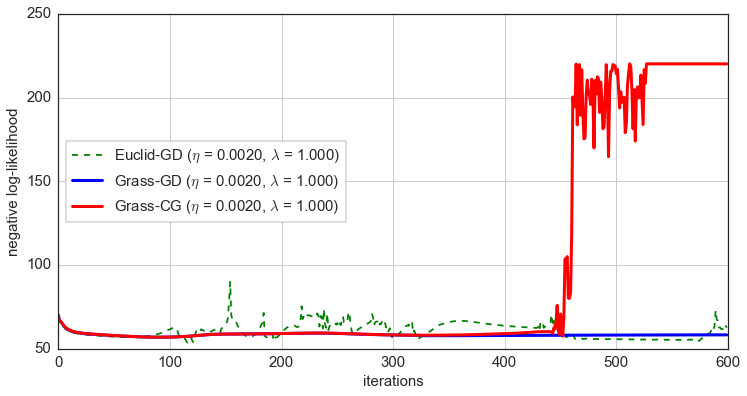

In [ ]:
fig= plt.figure(1)
fig.set_size_inches(12.0, 6.0*len(eta_array))
plt.style.use('seaborn-white')

for i, eta in enumerate(eta_array):
    ax = plt.subplot(len(eta_array),1,i+1)
    h1, = plt.plot(np.arange(max_iters), hist_nll_eu_array[i], '--g')
    h2, = plt.plot(np.arange(max_iters), hist_nll_grass_array[i], '-b', linewidth=3.0)
    h3, = plt.plot(np.arange(max_iters), hist_nll_conjugate_grass_array[i], '-r', linewidth=3.0)

    if add_reg:
        ax.legend([h1, h2, h3], [r"Euclid-GD ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f})".format(eta, lambda_var), \
                                 r"Grass-GD ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f})".format(eta, lambda_var), \
                                 r"Grass-CG ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f})".format(eta, lambda_var)], \
                                 fontsize = 15, loc='center left', frameon=True)
    else:    
        ax.legend([h1, h2, h3], [r"Euclid-GD ($\eta$ = {0:6.5f})".format(eta), r"Grass-GD ($\eta$ = {0:6.5f})".format(eta), \
                                 r"Grass-CG ($\eta$ = {0:6.5f})".format(eta)], \
                             fontsize = 15, loc='upper left', frameon=True)
    plt.grid(1)
    plt.ylabel('negative log-likelihood', fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #ax.set_ylim([60, 120])
plt.show    
if Ifsavefig:
    file_org = "../figures/04_14_16_" + str(trial) + "_"
    file_tail = "_nll_iters_GrassCG_GD_EuGD.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

In [ ]:
fig= plt.figure(2)
fig.set_size_inches(12.0, 6.0*len(eta_array))
plt.style.use('seaborn-white')

for i, eta in enumerate(eta_array):
    ax = plt.subplot(len(eta_array),1,i+1)
    h1, = plt.plot(np.arange(max_iters), hist_Hsig_array[i][:,0], 'b')
    h2, = plt.plot(np.arange(max_iters), hist_Hsig_array[i][:,1], 'r')
    if add_reg:
        ax.legend([h1, h2], [r"(Grass-GD) 1st singular value ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_var), \
                             r"(Grass-GD) 2nd singular value ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_var)], \
                             fontsize = 15, loc='upper center', frameon=True)
    else:    
        ax.legend([h1, h2], [r"1st singular value ($\eta$ = {0:6.5f})".format(eta), r"2nd singular value ($\eta$ = {0:5.4f})".format(eta)], \
                             fontsize = 15, loc='upper center', frameon=True)
    plt.grid(1)
    plt.ylabel('singular value', fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_14_16_" + str(trial) + "_"
    file_tail = "_sig_iters_Grass_GD.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

In [ ]:
fig= plt.figure(3)
fig.set_size_inches(12.0, 6.0*len(eta_array))
plt.style.use('seaborn-white')

for i, eta in enumerate(eta_array):
    ax = plt.subplot(len(eta_array),1,i+1)
    h1, = plt.plot(np.arange(max_iters), hist_Hsig_conjugate_array[i][:,0], 'b')
    h2, = plt.plot(np.arange(max_iters), hist_Hsig_conjugate_array[i][:,1], 'r')
    if add_reg:
        ax.legend([h1, h2], [r"(Grass-CG) 1st singular value ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_var), \
                             r"(Grass-CG) 2nd singular value ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_var)], \
                             fontsize = 15, loc='upper center', frameon=True)
    else:    
        ax.legend([h1, h2], [r"1st singular value ($\eta$ = {0:6.5f})".format(eta), r"2nd singular value ($\eta$ = {0:5.4f})".format(eta)], \
                             fontsize = 15, loc='upper center', frameon=True)
    plt.grid(1)
    plt.ylabel('singular value', fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_14_16_" + str(trial) + "_"
    file_tail = "_sig_iters_Grass_CG.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

In [ ]:
fig= plt.figure(4)
fig.set_size_inches(12.0, 6.0*len(eta_array))
plt.style.use('seaborn-white')

for i, eta in enumerate(eta_array):
    ax = plt.subplot(len(eta_array),1,i+1)
    h1, = plt.plot(np.arange(max_iters), hist_Gnorm_array[i], 'b')
    h2, = plt.plot(np.arange(max_iters), hist_Gnorm_conjugate_array[i], 'r')
    if add_reg:
        ax.legend([h1, h2], [r"(Grass-GD) G-norm ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_var), \
                             r"(Grass-CG) G-norm ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_var)], \
                             fontsize = 15, loc='upper center', frameon=True)
    else:    
        ax.legend([h1, h2], [r"(Grass-GD) G-norm ($\eta$ = {0:6.5f})".format(eta), r"(Grass-CG) G-norm ($\eta$ = {0:5.4f})".format(eta)], \
                             fontsize = 15, loc='upper center', frameon=True)
    plt.grid(1)
    plt.ylabel('norm value', fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_14_16_" + str(trial) + "_"
    file_tail = "_sig_iters_Gnorm_GDCG.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

In [ ]:
len(hist_gamma_array[i])

In [ ]:
fig= plt.figure(1)
fig.set_size_inches(12.0, 6.0*len(eta_array))
plt.style.use('seaborn-white')

for i, eta in enumerate(eta_array):
    ax = plt.subplot(len(eta_array),1,i+1)
    h1, = plt.semilogy(np.arange(max_iters), hist_condK_array[i], '--g')
    h2, = plt.semilogy(np.arange(max_iters), hist_condK_grass_array[i], '-b', linewidth=3.0)
    h3, = plt.semilogy(np.arange(max_iters), hist_condK_conjugate_array[i], '-r', linewidth=3.0)

    if add_reg:
         ax.legend([h1, h2, h3], [r"Euclid-GD ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f})".format(eta, lambda_var), \
                                  r"Grass-GD ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f})".format(eta, lambda_var), \
                                  r"Grass-CG ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f})".format(eta, lambda_var)], \
                             fontsize = 15, loc='upper left', frameon=True)
    else:    
        ax.legend([h1, h2, h3], [r"Euclid-GD ($\eta$ = {0:6.5f})".format(eta), r"Grass-GD ($\eta$ = {0:6.5f})".format(eta), \
                                 r"Grass-CG ($\eta$ = {0:6.5f})".format(eta)], \
                             fontsize = 15, loc='upper left', frameon=True)
    plt.grid(1)
    plt.ylabel('condition number of K', fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_14_16_" + str(trial) + "_"
    file_tail = "_nll_iters_condK.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

In [ ]:
fig= plt.figure(1)
fig.set_size_inches(12.0, 6.0*len(eta_array))
plt.style.use('seaborn-white')

for i, eta in enumerate(eta_array):
    ax = plt.subplot(len(eta_array),1,i+1)
    h1, = plt.semilogy(np.arange(max_iters), hist_cond2K_array[i], '--g')
    h2, = plt.semilogy(np.arange(max_iters), hist_cond2K_grass_array[i], '-b', linewidth=3.0)
    h3, = plt.semilogy(np.arange(max_iters), hist_cond2K_conjugate_array[i], '-r', linewidth=3.0)

    if add_reg:
         ax.legend([h1, h2, h3], [r"Euclid-GD ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f})".format(eta, lambda_var), \
                                  r"Grass-GD ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f})".format(eta, lambda_var), \
                                  r"Grass-CG ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f})".format(eta, lambda_var)], \
                             fontsize = 15, loc='upper center', frameon=True)
        #ax.legend([h3], [r"Conjugate Grassmann ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i])], \
        #                     fontsize = 15, loc='upper center', frameon=True)
    else:    
        ax.legend([h1, h2, h3], [r"Euclid-GD ($\eta$ = {0:6.5f})".format(eta), r"Grass-GD ($\eta$ = {0:6.5f})".format(eta), \
                                 r"Grass-CG ($\eta$ = {0:6.5f})".format(eta)], \
                             fontsize = 15, loc='upper center', frameon=True)
    plt.grid(1)
    plt.ylabel('condition number of dL/dK', fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_14_16_" + str(trial) + "_"
    file_tail = "_nll_iters_cond2K.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

In [ ]:
fig= plt.figure(5)
fig.set_size_inches(12.0, 6.0*len(eta_array))
plt.style.use('seaborn-white')

for i, eta in enumerate(eta_array):
    ax = plt.subplot(len(eta_array),1,i+1)
    #h1, = plt.plot(np.arange(max_iters), hist_Gnorm_array[i], 'b')
    h1, = plt.plot(np.arange(max_iters), hist_gamma_array[i], 'r')
    if add_reg:
        ax.legend([h1], [r"(Grass-CG) $\gamma$ ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_var)], \
                             fontsize = 15, loc='center', frameon=True)
        #ax.legend([h1, h2], [r"(Grass-GD) G-norm ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i]), \
        #                     r"(Grass-CG) G-norm ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i])], \
        #                     fontsize = 15, loc='upper center', frameon=True)
    else:    
        ax.legend([h1, h2], [r"(Grass-GD) G-norm ($\eta$ = {0:6.5f})".format(eta), r"(Grass-CG) G-norm ($\eta$ = {0:5.4f})".format(eta)], \
                             fontsize = 15, loc='lower center', frameon=True)
    plt.grid(1)
    plt.ylabel(r"$\gamma$", fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_14_16_" + str(trial) + "_"
    file_tail = "_sig_iters_gamma_CG.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

In [ ]:
fig= plt.figure(6)
fig.set_size_inches(12.0, 6.0*len(eta_array))
plt.style.use('seaborn-white')

for i, eta in enumerate(eta_array):
    ax = plt.subplot(len(eta_array),1,i+1)
    #h1, = plt.plot(np.arange(max_iters), hist_Gnorm_array[i], 'b')
    h1, = plt.plot(np.arange(max_iters), hist_deltaG_array[i], 'r')
    if add_reg:
        ax.legend([h1], [r"(Grass-CG) $<G - \tau G, G>$ ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_var)], \
                             fontsize = 15, loc='lower center', frameon=True)
        #ax.legend([h1, h2], [r"(Grass-GD) G-norm ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i]), \
        #                     r"(Grass-CG) G-norm ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i])], \
        #                     fontsize = 15, loc='upper center', frameon=True)
    else:    
        ax.legend([h1, h2], [r"(Grass-GD) G-norm ($\eta$ = {0:6.5f})".format(eta), r"(Grass-CG) G-norm ($\eta$ = {0:5.4f})".format(eta)], \
                             fontsize = 15, loc='lower center', frameon=True)
    plt.grid(1)
    plt.ylabel(r"$\Delta G$", fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_14_16_" + str(trial) + "_"
    file_tail = "_sig_iters_dG_CG.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

In [ ]:
fig= plt.figure(6)
fig.set_size_inches(12.0, 6.0*len(eta_array))
plt.style.use('seaborn-white')

for i, eta in enumerate(eta_array):
    ax = plt.subplot(len(eta_array),1,i+1)
    #h1, = plt.plot(np.arange(max_iters), hist_Gnorm_array[i], 'b')
    h1, = plt.plot(np.arange(max_iters), hist_kern_grass_array[i][:,2], 'b')
    h2, = plt.plot(np.arange(max_iters), hist_kern_grass2_array[i][:,2], 'r')
    if add_reg:
        ax.legend([h1, h2], [r"(Grass-GD) $\beta$ ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_var), \
                             r"(Grass-CG) $\beta$ ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_var)], \
                             fontsize = 15, loc='lower center', frameon=True)
    else:    
        ax.legend([h1, h2], [r"(Grass-GD) $\beta$ ($\eta$ = {0:6.5f})".format(eta), r"(Grass-CG) $\beta$ ($\eta$ = {0:5.4f})".format(eta)], \
                             fontsize = 15, loc='lower center', frameon=True)
    plt.grid(1)
    plt.ylabel(r"$\beta$ noise variance", fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ax.set_ylim([0,noise_interval[1]])
plt.show    
if Ifsavefig:
    file_org = "../figures/04_14_16_" + str(trial) + "_"
    file_tail = "_sig_iters_beta.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  